# Gradient descent to solve linear regression

We'll implement stochastic gradient descent from scratch, and use it to solve an ordinary least-squares linear regression.

Caveat: we don't actually use gradient descent, or the normal equation, to solve this problem. [Read why](https://towardsdatascience.com/why-gradient-descent-and-normal-equation-are-bad-for-linear-regression-928f8b32fa4f). The purpose of this notebook is to look at how gradient descent works.

---

First, let's look at what **gradient descent** is trying to do.

The basic idea is that we have some function we'd like to minimize. If you think of the function as a physical surface, we're going to try to walk (or ski!) down it to a minimum, hopefully the global minimum. 

The function we're trying to minimize is the **cost function**. This is whatever we want it to be, but in our example it's going to be the mean squared error... hence the name 'least squares solution'.

If we think of the cost function as a function of the **parameters** (weights, or coefficients), then we can use the partial derivative of the function with respect to each parameter to adjust that weight... although actually it turns out we can avoid updating the parameters separately by treating them as a single vector.

<img src="../images/gradient_descent.png" width="800px" />

## Load some data

We'll use our 'rocks' data:

In [1]:
import pandas as pd

df = pd.read_csv('https://geocomp.s3.amazonaws.com/data/RPC_simple.csv')

df.head()

,Vp,Vs,Rho_n,Lithology
0,3045.6,1595.7,2109.120585,sandstone
1,3000.6,1517.1,2090.342013,sandstone
2,3363.6,2041.5,2131.989982,sandstone
3,3195.3,1606.2,2184.939233,sandstone
4,4237.5,2448.6,2472.230768,sandstone


Let's try to predict `Vs` from `Vp` and `Rho_n`: 

In [2]:
data = df[['Vp', 'Rho_n', 'Vs']].values

<h3>Random data</h3>

<p>If you prefer, you can make a dataset from a multivariate normal distribution, so we can control the statistics of the features and target.</p>

<b>To do this, run the following code:</b>

<pre>
import numpy as np

num_samples = 100

# The desired mean values of the sample.
mu = np.array([5.0, 5.0, 10.0])

# The desired covariance matrix.
r = np.array([
        [  2.00,  0.00, -2.00],
        [  0.00,  2.00,  2.00],
        [ -2.00,  2.00,  4.00]
    ])

# Generate the random samples.
data = np.random.multivariate_normal(mu, r, size=num_samples)
</pre>

## Make `X` and `y`

We can visualize the data:

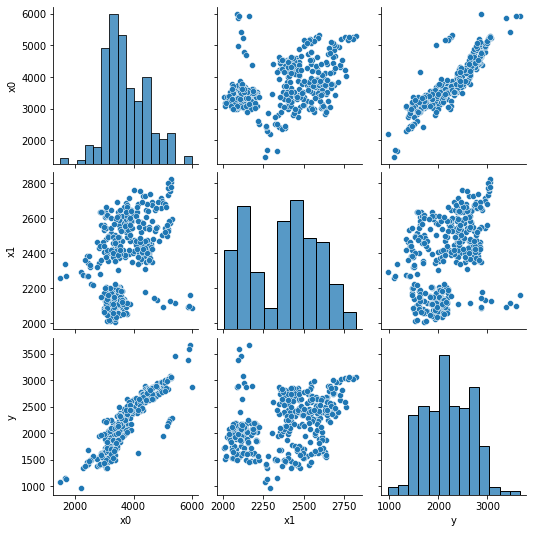

In [3]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(data, columns=['x0', 'x1', 'y'])

sns.pairplot(df, )

In [4]:
X = data[:, 0:2]
y = data[:, 2]

print(X.shape, y.shape)

(400, 2) (400,)


In [5]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

## Solve with `sklearn`

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression().fit(X, y)

y_pred = model.predict(X)
print(f"MSE: {mean_squared_error(y, y_pred):.3f}\n")

(w0, w1), b = model.coef_, model.intercept_
print(f"w0 = {w0:.3f}\nw1 = {w1:.3f}\nb = {b:.3f}")

MSE: 46323.501

w0 = 424.551
w1 = 17.800
b = 2188.855


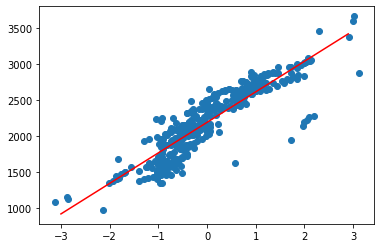

In [7]:
import numpy as np
import matplotlib.pyplot as plt

X_plt = np.arange(-3, 3, 0.1)
y_plt_sk = model.coef_[0]*X_plt + model.coef_[1]*0 + model.intercept_

plt.scatter(X[:, 0], y) 
plt.plot(X_plt, y_plt_sk, color='r')
plt.show()

## Closed form solution

There's actually a linear algebraic way to solve this equation. In principle, this is much faster and easier to do than gradient descent. In practice, it might not be possible, e.g. on very large datasets, or with custom loss functions.

One way to solve the problem is with ordinary least-squares and the so-called [**normal equation**](https://en.wikipedia.org/wiki/Linear_least_squares#Derivation_of_the_normal_equations):

$$ \mathbf{y} = \mathbf{w}\mathbf{X} $$

We want the weights $\mathbf{w}$, so:

$$ \mathbf{w} = \mathbf{X}^{-1}\mathbf{y} $$

The catch is that $\mathbf{X}^{-1}$ may not be possible to compute, so we have to use [the pseudoinverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse) of `X`.

This approach is easier if we add a column of 1's to `X`, and concatenate the weights `w` with the bias `b`, so that we have a single data matrix and a single weight vector:

In [8]:
N = X.shape[0]
X_ = np.c_[X, np.ones((N, 1))]

That [`np.c_`](https://numpy.org/doc/stable/reference/generated/numpy.c_.html) implements a concatenation trick. You can also use `np.hstack`.

Now we can implement the 'naive' version of the normal equation:

In [9]:
np.set_printoptions(suppress=True)

In [10]:
import numpy.linalg as la

X_inv = la.inv(X_.T @ X_) @ X_.T  # The 'pseudoinverse' of X.

X_inv @ y

array([ 424.55148965,   17.80024655, 2188.85530053])

We solved it! Pretty cool. But it won't always work...

## Gradient descent

Let's solve the problem using gradient descent.

In order to optimize the weights using gradient descent, we need to know the **gradient** of the **cost function**. The cost $C$ over $N$ samples is given by:

$$ C = \frac{1}{N} \sum_{i=0}^{N} (\mathbf{y}_i - \hat{\mathbf{y}}_i)^2 $$

where the estimate $\hat{\mathbf{y}}$ is given by the matrix product of the weights $\theta$ and the 'augmented' data $\bar{\mathbf{X}}$ (the data plus an extra column of ones):

$$ \hat{\mathbf{y}} = \mathbf{w} \mathbf{X} + b = \theta \bar{\mathbf{X}} $$

Using this 'combined' weight matrix is easier than dealing with the weights and bias term separately. Note that $\theta$ is a vector, although it's displayed with an italic character here.

#### Chain rule

There are 2 functions here: the expression for $C$ and the one for $\hat{\mathbf{y}}$. The chain rule tells us how to differentiate a function of a function:

$$ \frac{\mathrm{d}}{\mathrm{d}x}[f(g(x))] = f^\prime(g(x))\ \times\ g^\prime(x) $$

Therefore the gradient $g$ is given by:

$$ g = \frac{\mathrm{d}C}{\mathrm{d}\theta} = \frac{\mathrm{d}C}{\mathrm{d}\hat{\mathbf{y}}}\ \times\ \frac{\mathrm{d}\hat{\mathbf{y}}}{\mathrm{d}\theta} $$

So our problem now looks like this:

$$ g = \frac{2}{N}\sum_{i=0}^{N} (\mathbf{y}_i - \hat{\mathbf{y}}_i)\ \times\ -\mathbf{X}_i $$

so if the error $\mathbf{e} = (\mathbf{y} - \hat{\mathbf{y}})$ then:

$$ g = -\frac{2}{N}\sum_{i=0}^{N} \mathbf{e}_i \mathbf{X}_i $$

In [11]:
alpha = 0.001
epochs = 5_000

# Initialize.
cost_history = []
theta = np.zeros(3)

for i in range(epochs):
    # Make estimate with current weights.
    y_hat = theta @ X_.T
    
    # Compute error and cost.
    err = y - y_hat
    cost = np.sum(err**2) / N
    cost_history.append(cost)
    if i % (epochs // 10) == 0:
        print(f"{i:>8d} {cost:.3f}")
        
    # Compute gradients (one for each feature).
    grad = (-2/N) * np.sum(err[:, None] * X_, axis=0)
    
    # Adjust weights.
    theta -= alpha * grad

print(f"{'end':>8s} {cost:.3f}")

       0 5023924.206
     500 716699.425
    1000 138668.952
    1500 59477.131
    2000 48311.470
    2500 46655.391
    3000 46387.204
    3500 46337.719
    4000 46327.090
    4500 46324.482
     end 46323.782


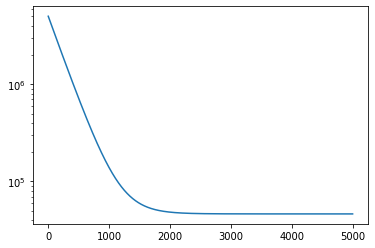

In [12]:
plt.plot(cost_history)
plt.yscale('log')

Let's make sure it's similar to what we got before, which was

In [13]:
# With sklearn...
w0, w1, b

(424.55148964956726, 17.800246550450083, 2188.8553005275003)

In [14]:
# With gradient descent...
theta

array([ 424.07910874,   18.27224375, 2188.75691675])

## Stochastic gradient descent

Here, we're computing the cost over the entire dataset. In practice, this might not be possible, especially on high-dimensional datasets. We can reduce the computational burden by computing the cost over smaller 'batches'. This is known as 'stochastic gradient descent'. 

We'll also shuffle the data before each epoch (one epoch is one pass through the entire dataset). This helps to avoid getting stuck in a local minimum, because every time we take a step on the cost surface, we're on a slightly different version of the surface.

In [15]:
alpha = 0.001
epochs = 1000
batch_size = 50

splits = np.arange(batch_size, N, batch_size)
idx = np.arange(N)

# Initialize.
cost_history = []
theta = np.random.random(3)

for i in range(epochs):
    
    # Shuffle the data.
    np.random.shuffle(idx)
    X_shuffle = X_[idx]
    y_shuffle = y[idx]
    X_batches = np.split(X_shuffle, splits)
    y_batches = np.split(y_shuffle, splits)

    for j, (X_batch, y_batch) in enumerate(zip(X_batches, y_batches)):

        # Make estimate with current weights.
        y_hat = theta @ X_batch.T

        # Compute error and (once per epoch) cost.
        err = y_batch - y_hat
        
        if j == 0:
            cost = np.sum(err**2) / batch_size
            cost_history.append(cost)

        # Compute gradients (one for each feature).
        grad = (-2/batch_size) * np.sum(err[:, None] * X_batch, axis=0)

        # Adjust weights.
        theta -= alpha * grad

    if i % (epochs // 10) == 0:
        print(f"{i:>8d} {cost:.3f}")

print(f"{'end':>8s} {cost:.3f}")

       0 5288626.711
     100 236427.280
     200 61450.448
     300 53628.283
     400 44419.047
     500 44272.707
     600 68196.515
     700 30796.247
     800 45733.097
     900 44765.674
     end 61762.913


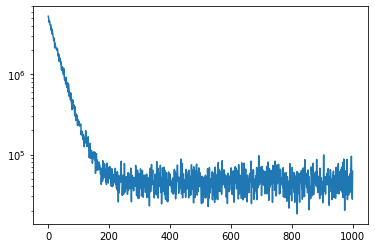

In [16]:
plt.plot(cost_history)
plt.yscale('log')

Notice that this converges much faster than using the entire dataset.

In [17]:
theta

array([ 424.54159652,   17.8200639 , 2188.86277195])

This compares well with what we got from `sklearn`:

In [18]:
w0, w1, b

(424.55148964956726, 17.800246550450083, 2188.8553005275003)

And let's check the new parameters against the previous solution:

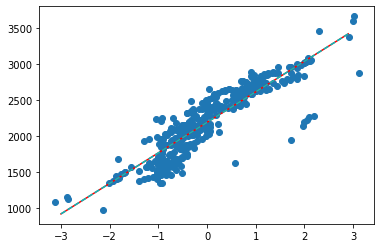

In [19]:
w0_sgd, w1_sgd, b_sgd = theta

y_plt = w0_sgd*X_plt + w1_sgd*0 + b_sgd

plt.scatter(X[:, 0], y) 
plt.plot(X_plt, y_plt_sk, color='r')  # regression line
plt.plot(X_plt, y_plt, '--', color='c')  # regression line
plt.show()

It matches!

----

&copy; 2020 Agile Scientific